In [26]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt 
from utils import *
from kernel_sca_inducing_points import *
from kernels import *
import plotly.graph_objs as go
import plotly.express as px 

In [20]:
def get_PSTH(epoch):
    config_rf_ls = ['Ar', 'Ag', 'Br', 'Bg']
    leaders = []
    supporters = []
    for config_rf in config_rf_ls:
        mat_data = scipy.io.loadmat(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/Per epoch/Leaders/{epoch}{config_rf}.mat')
        data = np.array(mat_data[epoch])
        for i in range(data.shape[0]):
            leaders.append(np.vstack(data[i]))
        
        mat_data = scipy.io.loadmat(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/Per epoch/Supporters/{epoch}{config_rf}.mat')
        data = np.array(mat_data[epoch])
        for i in range(data.shape[0]):
            supporters.append(np.vstack(data[i]))
        
        
    np.stack(leaders)
    np.stack(supporters)
    return np.concatenate((leaders, supporters))


DotsOn = get_PSTH('DotsOn')
LibSacc = get_PSTH('LibSacc')
Slib = get_PSTH('Slib')
LastFix = get_PSTH('LastFix')
ChoiceSacc = get_PSTH('ChoiceSacc')
X = np.concatenate((DotsOn, LibSacc, Slib, LastFix, ChoiceSacc), axis=2).swapaxes(0,1)
X, _ = pre_processing(X, soft_normalize='max', num_pcs=10, center=False)

K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)  

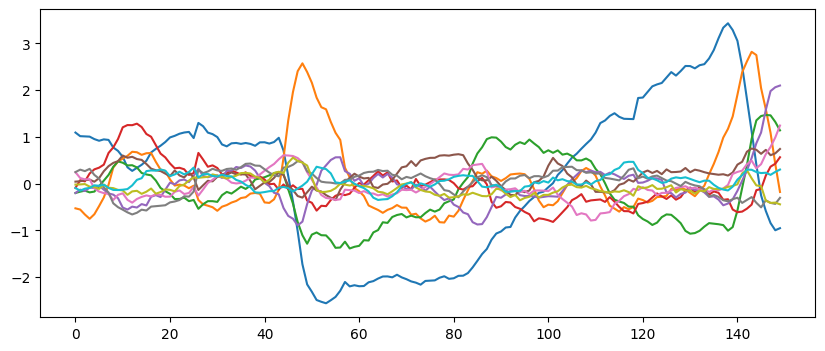

In [21]:
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.plot( X[-1,i,:] )

In [22]:
d = 3
c = 30
kernel_function = K_X_Y_squared_exponential

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=100, learning_rate=0.1, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 7.878738880157471, S_ratio: 0.3857906460762024
Iteration 10, S: 76.22130584716797, S_ratio: 0.36102211475372314
Iteration 20, S: 108.52078247070312, S_ratio: 0.3981498181819916
Iteration 30, S: 90.26461029052734, S_ratio: 0.4145413339138031
Iteration 40, S: 109.27136993408203, S_ratio: 0.41503018140792847
Iteration 50, S: 161.98963928222656, S_ratio: 0.4122069180011749
Iteration 60, S: 137.5635223388672, S_ratio: 0.4245149493217468
Iteration 70, S: 135.22679138183594, S_ratio: 0.41715121269226074
Iteration 80, S: 146.06324768066406, S_ratio: 0.4156295955181122
Iteration 90, S: 120.838134765625, S_ratio: 0.42500317096710205


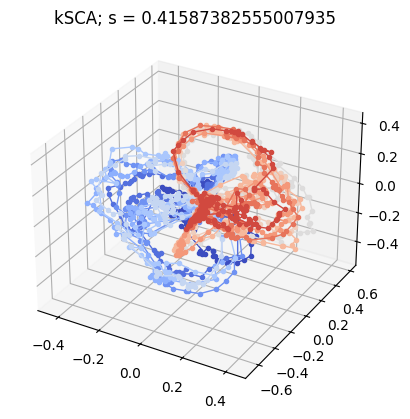

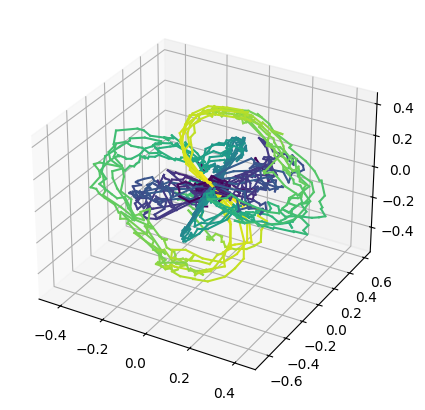

In [32]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.coolwarm
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :] 
    color = cmap(k / K)
    ax.plot(x, y, z, linestyle='-', marker='.', linewidth=1, color=color)

plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

plot_3D(Y[:,:,:])

In [31]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()